In [ ]:
from svmutil import *
import csv
import math
import random
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def read_from_file(path):
    data = []
    with open(path) as f:
        reader = csv.reader(f, delimiter=",")
        for row in reader:
            data.append([row[:-1], row[-1]])
    for column in range(len(data[0][0])):
        for row in data:
            row[0][column] = float(row[0][column].strip())
    return data


def write_data_for_scale(file_name, data):
    f = open(file_name, 'w')
    for row in data:
        line = str(row[-1])
        for i in xrange(len(row[0])):
                line += ' ' + str(i + 1) + ':' + str(row[0][i])
        line = line + '\n'
        f.write(line)
    f.close()


def get_standard_deviation(y_test, p_labels):
    errors = [y_test[i] - p_labels[i] for i in xrange(len(y_test))]
    std = np.std(errors)
    return std


def kfold_cross_validation(params, features, k, seed=None):
    partitions = partition(features, k, seed)
    errors = list()
    count_support_vectors = list()
    # Run the algorithm k times, record error each time
    for i in range(k):
        trainingSet = list()
        for j in range(k):
            if j != i:
                trainingSet.append(partitions[j])

        # flatten training set
        trainingSet = [item for entry in trainingSet for item in entry]
        testSet = partitions[i]
        y_train = [row[0] for row in trainingSet]
        x_train = [row[1] for row in trainingSet]
        # Train and classify model
        prob = svm_problem(y_train, x_train)
        trainedClassifier = svm_train(prob, params)
        y_test = [row[0] for row in testSet]
        x_test = [row[1] for row in testSet]
        p_labels, p_acc, p_vals = svm_predict(y_test, x_test, trainedClassifier, '-q')
        errors.append(p_acc[1])
        count_support_vectors.append(trainedClassifier.get_nr_sv())
    std = np.std(errors)
    mean = np.mean(errors)
    count = np.mean(count_support_vectors)
    print 'mean:', mean, ' std:', std, ' count vectors: ', count
    return mean, std, count


def partition(dataSet, k, seed=None):
    size = math.ceil(len(dataSet) / float(k))
    partitions = [[] for i in range(k)]
    j = 0

    for entry in dataSet:
        x = assign(partitions, k, size, seed)
        partitions[x].append(entry)

    return partitions


def assign(partitions, k, size, seed=None):
    if seed is not None:
        random.Random(seed)
    x = random.randint(0,k-1)
    while len(partitions[x]) >= size:
        x = random.randint(0,k-1)
    return x


def scale_data(file_path):
    data = read_from_file(file_path)
    train_file_name = "train"
    test_file_name = "test"
    train = data[:3450]
    test = data[3450:]
    write_data_for_scale(train_file_name, train)
    write_data_for_scale(test_file_name, test)
    args = "svm-scale.exe -l 0 -u 1 -s scale_params " + train_file_name
    fnull = open(os.devnull, 'w')
    train_file = open(train_file_name + '.scaled', 'w')
    subprocess.call(args, stdout=train_file, stderr=fnull, shell=False)
    train_file.close()
    test_file = open(test_file_name + ".scaled", 'w')
    args = "svm-scale.exe -l 0 -u 1 -r scale_params " + test_file_name
    subprocess.call(args, stdout=test_file, stderr=fnull, shell=False)
    test_file.close()
    fnull.close()

In [39]:
scale_data("sample.txt")
y_train, x_train = svm_read_problem("train.scaled")
y_test, x_test = svm_read_problem("test.scaled")
train_data = [[y_train[i], x_train[i]] for i in xrange(len(x_train))]
test_data = [[y_test[i], x_test[i]] for i in xrange(len(x_test))]
print train_data[0:10]

[[0.0, {1: 0.0176211, 2: 0.0119048, 3: 0.0333333, 36: 0.0735294, 5: 0.0880088, 6: 0.0136054, 8: 0.0429043, 42: 0.00560224, 43: 0.022409, 12: 0.350569, 13: 0.0306306, 16: 0.004, 49: 0.00524515, 50: 0.00471698, 57: 0.0274621, 53: 0.00383142, 55: 0.00162469, 56: 0.00560673, 25: 0.128661, 37: 0.011611}], [0.0, {35: 0.111, 19: 0.1184, 57: 0.00138889, 55: 0.000753552, 56: 0.000700841, 25: 0.106577, 26: 0.133253}], [0.0, {9: 0.220532, 12: 0.119959, 13: 0.209009, 19: 0.0618667, 21: 0.10831, 55: 0.000195982, 56: 0.00020024, 57: 0.000694444, 27: 0.0348035}], [0.0, {10: 0.130913, 12: 0.492244, 52: 0.0136092, 55: 0.0011024, 56: 0.000901081, 57: 0.0010101}], [1.0, {3: 0.0627451, 5: 0.0715072, 6: 0.110544, 7: 0.0440165, 8: 0.0528053, 12: 0.033092, 13: 0.0576577, 45: 0.0149393, 16: 0.016, 17: 0.0448179, 50: 0.0108696, 19: 0.1216, 56: 0.000901081, 21: 0.304388, 55: 0.000484076, 24: 0.0328205, 57: 0.00871212, 53: 0.0264868}], [0.0, {56: 0.00030036, 57: 0.00094697, 55: 0.00022538}], [1.0, {1: 0.0770925,

In [7]:
def start_calculation(degree):
    x = []
    top = []
    middle = []
    bottom = []
    for k in xrange(-10, 21):
        print 'k:', k
        svm_params = svm_parameter('-s 0 -t 1 -q -d ' + str(d) + ' -c ' + str(2**k))
        error, std, count = kfold_cross_validation(svm_params, train_data, k_fold_param)
        x.append(k)
        top.append(error)
        middle.append(error)
        bottom.append(error)
    return x, top, middle, bottom

In [8]:
def draw_error(x, error_top, error, error_bottom):
    plt.figure(1)
    plt.subplot(211)
    plt.plot(x, error_top)
    plt.subplot(211)
    plt.plot(x, error)
    plt.subplot(211)
    plt.plot(x, error_bottom)

    plt.show()

In [9]:
k_fold_param = 10
d = 1
x1, top1, middle1, bottom1 = start_calculation(d)

k: -10
mean: 0.392753623188  std: 0.0273218196969
k: -9
mean: 0.392753623188  std: 0.0201339767963
k: -8
mean: 0.392753623188  std: 0.0240858926499
k: -7
mean: 0.392753623188  std: 0.025310506082
k: -6
mean: 0.392753623188  std: 0.0164094838895
k: -5
mean: 0.392753623188  std: 0.0193248791893
k: -4
mean: 0.392753623188  std: 0.0179265461983
k: -3
mean: 0.392753623188  std: 0.0299056838492
k: -2
mean: 0.392753623188  std: 0.0174033774519
k: -1
mean: 0.391884057971  std: 0.0185507246377
k: 0
mean: 0.349855072464  std: 0.0255352283933
k: 1
mean: 0.202898550725  std: 0.0246291545348
k: 2
mean: 0.165217391304  std: 0.0203725024821
k: 3
mean: 0.143188405797  std: 0.0145043431921
k: 4
mean: 0.125797101449  std: 0.0169112488647
k: 5
mean: 0.109275362319  std: 0.0164503926071
k: 6
mean: 0.0968115942029  std: 0.0123792211618
k: 7
mean: 0.0857971014493  std: 0.0111660059619
k: 8
mean: 0.0811594202899  std: 0.0130273652488
k: 9
mean: 0.0765217391304  std: 0.0163556359185
k: 10
mean: 0.075652173913

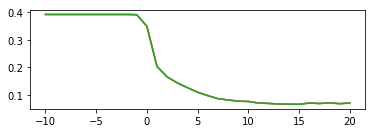

In [10]:
draw_error(x1, top1, middle1, bottom1)

In [11]:
d = 2
x2, top2, middle2, bottom2 = start_calculation(d)

k: -10
mean: 0.392753623188  std: 0.0293097803133
k: -9
mean: 0.392753623188  std: 0.0232697847379
k: -8
mean: 0.392753623188  std: 0.0261914172615
k: -7
mean: 0.392753623188  std: 0.0235924936175
k: -6
mean: 0.392753623188  std: 0.0245693853076
k: -5
mean: 0.392753623188  std: 0.0294242162012
k: -4
mean: 0.392753623188  std: 0.0352921613388
k: -3
mean: 0.392753623188  std: 0.02242399471
k: -2
mean: 0.392753623188  std: 0.0166635157702
k: -1
mean: 0.392753623188  std: 0.0220842175638
k: 0
mean: 0.392753623188  std: 0.0152415267538
k: 1
mean: 0.392753623188  std: 0.0192813546314
k: 2
mean: 0.392753623188  std: 0.0174033774519
k: 3
mean: 0.392753623188  std: 0.0291661040543
k: 4
mean: 0.392753623188  std: 0.0241207492422
k: 5
mean: 0.392753623188  std: 0.0230885531258
k: 6
mean: 0.392753623188  std: 0.026255494219
k: 7
mean: 0.391884057971  std: 0.0258215158856
k: 8
mean: 0.379710144928  std: 0.0290434204055
k: 9
mean: 0.298260869565  std: 0.0187153025593
k: 10
mean: 0.24231884058  std: 

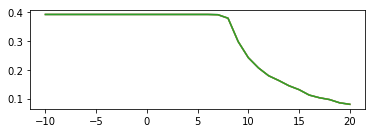

In [12]:
draw_error(x2, top2, middle2, bottom2)

In [13]:
d = 3
x3, top3, middle3, bottom3 = start_calculation(d)

k: -10
mean: 0.392753623188  std: 0.0186162790995
k: -9
mean: 0.392753623188  std: 0.021622877567
k: -8
mean: 0.392753623188  std: 0.0174033774519
k: -7
mean: 0.392753623188  std: 0.0260305347978
k: -6
mean: 0.392753623188  std: 0.032465062086
k: -5
mean: 0.392753623188  std: 0.0175476068031
k: -4
mean: 0.392753623188  std: 0.016047084679
k: -3
mean: 0.392753623188  std: 0.0283184103924
k: -2
mean: 0.392753623188  std: 0.0230885531258
k: -1
mean: 0.392753623188  std: 0.02323365151
k: 0
mean: 0.392753623188  std: 0.0136108485587
k: 1
mean: 0.392753623188  std: 0.0245008990829
k: 2
mean: 0.392753623188  std: 0.0208312853436
k: 3
mean: 0.392753623188  std: 0.0186162790995
k: 4
mean: 0.392753623188  std: 0.020951930862
k: 5
mean: 0.392753623188  std: 0.0198820297271
k: 6
mean: 0.392753623188  std: 0.0245693853076
k: 7
mean: 0.392753623188  std: 0.0298775769972
k: 8
mean: 0.392753623188  std: 0.0270746981047
k: 9
mean: 0.392753623188  std: 0.0180200359912
k: 10
mean: 0.392753623188  std: 0.

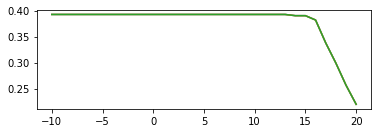

In [14]:
draw_error(x3, top3, middle3, bottom3)

In [15]:
d = 4
x4, top4, middle4, bottom4 = start_calculation(d)

k: -10
mean: 0.392753623188  std: 0.0140960190328
k: -9
mean: 0.392753623188  std: 0.0166635157702
k: -8
mean: 0.392753623188  std: 0.0214668944479
k: -7
mean: 0.392753623188  std: 0.0319432914872
k: -6
mean: 0.392753623188  std: 0.0286135555245
k: -5
mean: 0.392753623188  std: 0.0201756620931
k: -4
mean: 0.392753623188  std: 0.035905778821
k: -3
mean: 0.392753623188  std: 0.0425060382184
k: -2
mean: 0.392753623188  std: 0.0158892406651
k: -1
mean: 0.392753623188  std: 0.0284663654767
k: 0
mean: 0.392753623188  std: 0.0176431046882
k: 1
mean: 0.392753623188  std: 0.0302686979712
k: 2
mean: 0.392753623188  std: 0.0258686517924
k: 3
mean: 0.392753623188  std: 0.0247737080381
k: 4
mean: 0.392753623188  std: 0.0166635157702
k: 5
mean: 0.392753623188  std: 0.0183892428122
k: 6
mean: 0.392753623188  std: 0.0207504653091
k: 7
mean: 0.392753623188  std: 0.0223113106063
k: 8
mean: 0.392753623188  std: 0.0257710338903
k: 9
mean: 0.392753623188  std: 0.0357885925462
k: 10
mean: 0.392753623188  st

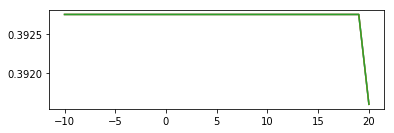

In [16]:
draw_error(x4, top4, middle4, bottom4)

In [43]:
def start_calculation_with_c(dataset, c):
    x = []
    errors = []
    counts = []
    for d in xrange(1, 10):
        print d
        svm_params = svm_parameter('-s 0 -t 1 -q -d ' + str(d) + ' -c ' + str(c))
        error, std, count = kfold_cross_validation(svm_params, dataset, k_fold_param)
        errors.append(error)
        counts.append(count)
        x.append(d)
    return x, errors, counts

def draw_plot(x, y):
    plt.plot(x, y)
    plt.show()

In [47]:
best_c = 2**14
best_d = 1

1
mean: 0.0666666666667  std: 0.00342961146846  count vectors:  624.4
2
mean: 0.145797101449  std: 0.0129659531863  count vectors:  1355.2
3
mean: 0.390434782609  std: 0.0303463172527  count vectors:  2458.8
4
mean: 0.392753623188  std: 0.0275667260594  count vectors:  2456.0
5
mean: 0.392753623188  std: 0.0351251251548  count vectors:  2439.7
6
mean: 0.392753623188  std: 0.0231249130745  count vectors:  2439.0
7
mean: 0.392753623188  std: 0.0192377316012  count vectors:  2439.1
8
mean: 0.392753623188  std: 0.02873076464  count vectors:  2439.0
9
mean: 0.392753623188  std: 0.0350293182933  count vectors:  2439.0


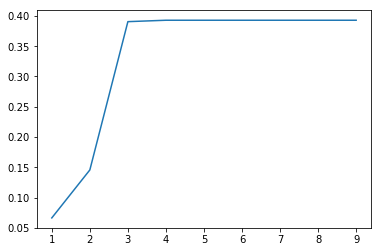

In [55]:
x, errors, count = start_calculation_with_c(train_data, best_c)
draw_plot(x, errors)

1
mean: 0.08449081534  std: 0.031280144996  count vectors:  239.8
2
mean: 0.194849454608  std: 0.0437693272064  count vectors:  574.1
3
mean: 0.395988661075  std: 0.0390460825931  count vectors:  838.9
4
mean: 0.39804713291  std: 0.0625973257468  count vectors:  836.8
5
mean: 0.397582984209  std: 0.031900372281  count vectors:  824.6
6
mean: 0.398134583483  std: 0.0479229349261  count vectors:  824.6
7
mean: 0.397951840652  std: 0.0332041756617  count vectors:  824.4
8
mean: 0.397843370685  std: 0.0339922662623  count vectors:  824.4
9
mean: 0.397655494683  std: 0.029697203964  count vectors:  824.4


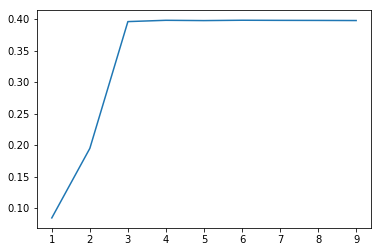

In [45]:
x, errors, count = start_calculation_with_c(test_data, best_c)
draw_plot(x, errors)

1
mean: 0.0893006767644  std: 0.031382864963  count vectors:  238.7
2
mean: 0.192794169067  std: 0.0429915256061  count vectors:  574.3
3
mean: 0.396249341138  std: 0.0441377040017  count vectors:  838.2
4
mean: 0.39780051563  std: 0.0474683858203  count vectors:  833.7
5
mean: 0.3977253077  std: 0.0421339549601  count vectors:  824.4
6
mean: 0.398109551419  std: 0.0471790769084  count vectors:  824.4
7
mean: 0.397945536578  std: 0.0394220149389  count vectors:  824.4
8
mean: 0.398162815213  std: 0.0437333805141  count vectors:  824.4
9
mean: 0.398143862645  std: 0.0572661795435  count vectors:  824.4


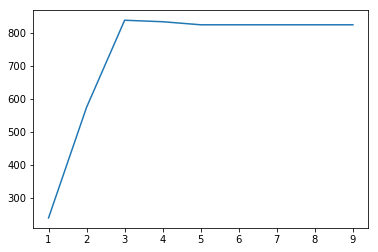

In [46]:
x, errors, counts = start_calculation_with_c(test_data, best_c)
draw_plot(x, counts)

In [54]:
# итоговое решение с наилучшими параметрами d=1, C=2^14
y_train = [row[0] for row in train_data]
x_train = [row[1] for row in train_data]
prob = svm_problem(y_train, x_train)
svm_params = svm_parameter('-s 0 -t 1 -d ' + str(best_d) + ' -c ' + str(best_c))
trainedClassifier = svm_train(prob, svm_params)
y_test = [row[0] for row in test_data]
x_test = [row[1] for row in test_data]
p_labels, p_acc, p_vals = svm_predict(y_test, x_test, trainedClassifier)
print 'count support vectors: ', trainedClassifier.get_nr_sv()

Accuracy = 91.9201% (1058/1151) (classification)
count support vectors:  688


In [56]:
# количество опорных векторов говорит о том, какую погрешность мы разрешаем алгоритму для разделения выборки.
# чем большее количество опорных векторов в итоговом решении, тем большая погрешность возможна.
# заметим, что для других параметров обучения, количество векторов на тренировочных данных больше, чем на оптимальном.
# также количество опорных векторов зависит от сложности модели. чем модель сложнее,
# тем больше опорных векторов мы будем получать.